In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from keras import Sequential, Input
from keras.src.layers import Conv1D, MaxPooling1D, Dropout, GlobalMaxPooling1D, Dense
from keras.src.utils import to_categorical
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('../Data/combined_data.csv')
df = df[df['speed'] == 2]
df = df[df['node-id'] == 563]
df = df.reset_index(drop=True)


In [3]:
# Divide the data into classes.
num_classes = 3
df['weight_class'] = pd.qcut(df['weight'], q=num_classes, labels=False)

In [4]:
# Group the DataFrame by 'weight_class' and get unique 'weight' in each group
weights_by_class= df.groupby('weight_class')['weight'].unique()

# Sort the weights in each class
weights_by_class= weights_by_class.apply(lambda x: sorted(list(x)))

weights_by_class

weight_class
0    [84.5, 86.25, 87.35, 89.15, 90.5, 91.95]
1              [93.4, 94.7, 96.3, 97.5, 99.1]
2         [100.5, 101.7, 103.0, 104.3, 105.7]
Name: weight, dtype: object

In [5]:
def split(df):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    for weight_class, weights in weights_by_class.items():
        test_indices = [1, 3] # Choose test indices 
        test_weights = [weights[i] for i in test_indices]
        train_weights = [weight for i, weight in enumerate(weights) if i not in test_indices]

        df_train = pd.concat([df_train, df[df['weight'].isin(train_weights) & (df['weight_class'] == weight_class)]], ignore_index=True)
        df_test = pd.concat([df_test, df[df['weight'].isin(test_weights) & (df['weight_class'] == weight_class)]], ignore_index=True)

    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_test

df_train, df_test = split(df)

In [6]:
# # Split the data for each weight into training and testing sets
# train_dfs = []
# test_dfs = []
# 
# for weight in df['weight'].unique():
#     weight_df = df[df['weight'] == weight]
#     train_weight_df, test_weight_df = train_test_split(weight_df, test_size=0.25, random_state=42)
#     train_dfs.append(train_weight_df)
#     test_dfs.append(test_weight_df)
# 
# # Concatenate the training and testing dataframes
# df_train = pd.concat(train_dfs).reset_index(drop=True)
# df_test = pd.concat(test_dfs).reset_index(drop=True)

In [7]:
# def split_sequentially(df, train_size=0.75):
#     train_dfs = []
#     test_dfs = []
# 
#     for weight in df['weight'].unique():
#         weight_df = df[df['weight'] == weight]
#         split_index = int(len(weight_df) * train_size)
#         train_weight_df = weight_df.iloc[:split_index]
#         test_weight_df = weight_df.iloc[split_index:]
# 
#         train_dfs.append(train_weight_df)
#         test_dfs.append(test_weight_df)
# 
#     train_df = pd.concat(train_dfs).reset_index(drop=True)
#     test_df = pd.concat(test_dfs).reset_index(drop=True)
# 
#     return train_df, test_df
# 
# df_train, df_test = split_sequentially(df)

In [8]:
N_features = 3

def get_segments(df, segment_size, step_size):
    segments = []
    labels = []
    
    for i in range(0, df.shape[0] - segment_size, step_size):
        # axs = df['ax'].values[i: i + segment_size]
        # ays = df['ay'].values[i: i + segment_size]
        # azs = df['az'].values[i: i + segment_size]
        gxs = df['gx'].values[i: i + segment_size]
        gys = df['gy'].values[i: i + segment_size]
        gzs = df['gz'].values[i: i + segment_size]
        label = df['weight_class'].iloc[i: i + segment_size].mode()[0]
        
        segments.append([gxs, gys, gzs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, N_features)
    labels = np.asarray(labels).reshape(-1, 1)
    
    return reshaped_segments, labels

In [9]:
segment_size = 400
step_size = 200

X_train, y_train = get_segments(df_train, segment_size, step_size)
X_test, y_test = get_segments(df_test, segment_size, step_size)


In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2998, 400, 3) (2998, 1)
(1798, 400, 3) (1798, 1)


In [11]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, N_features)).reshape(-1, segment_size, N_features)
X_test = scaler.transform(X_test.reshape(-1, N_features)).reshape(-1, segment_size, N_features)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2998, 400, 3) (2998, 3)
(1798, 400, 3) (1798, 3)


In [13]:
# Model
model = Sequential()
model.add(Input(shape=(segment_size, N_features)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 398, 16)        │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 199, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 195, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 97, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 90, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,395 (75.76 KB)

 Trainable params: 19,395 (75.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3773 - loss: 1.1677 - val_accuracy: 0.3443 - val_loss: 1.0969
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4112 - loss: 1.0838 - val_accuracy: 0.3854 - val_loss: 1.0852
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4152 - loss: 1.0812 - val_accuracy: 0.3621 - val_loss: 1.0913
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4228 - loss: 1.0677 - val_accuracy: 0.4110 - val_loss: 1.0759
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4356 - loss: 1.0631 - val_accuracy: 0.3532 - val_loss: 1.0859
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4454 - loss: 1.0565 - val_accuracy: 0.3604 - val_loss: 1.0851
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4378 - loss: 1.0552 - val_accuracy: 0.4483 - val_loss: 1.0555
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4455 - loss: 1.0478 - val_accuracy: 0.4205 - v

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.63      0.49       600
           1       0.47      0.34      0.39       600
           2       0.43      0.31      0.36       598

    accuracy                           0.43      1798
   macro avg       0.44      0.43      0.42      1798
weighted avg       0.44      0.43      0.42      1798



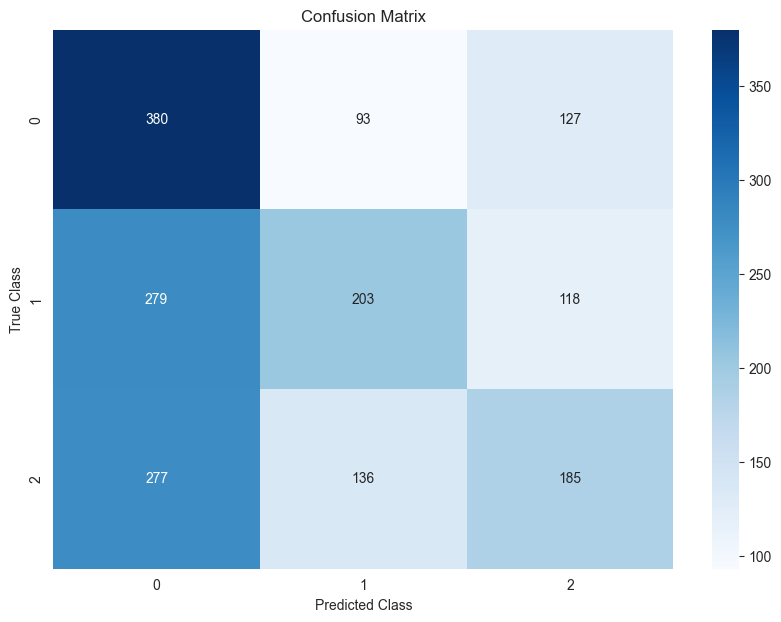

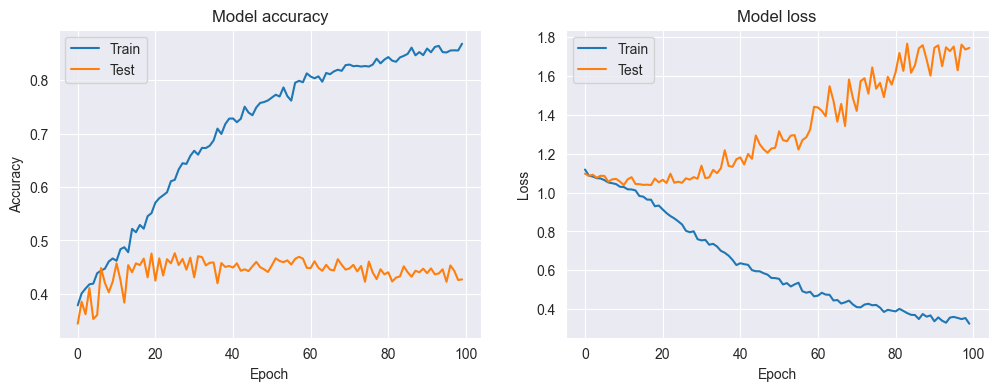

Test Loss: 1.743878960609436
Test Accuracy: 0.4271412789821625


In [15]:
res_dir = '../Results/CNN/High_speed/563/'
sensors = 'g'
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Predict the classes for the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:\n", report)

# Save the classification report
with open(res_dir + 'CNN_'+ sensors + '_classification_report.txt', 'w') as f:
    f.write(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig(res_dir + 'CNN_' + sensors + '_confusion_matrix.png')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(res_dir + 'CNN_' + sensors + '_accuracy_loss.png')
plt.show()

# Print final test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")